In [103]:
import random
from pathlib import Path

import numpy as np
import pandas as pd
from numba import njit, prange

from matplotlib import pyplot as plt

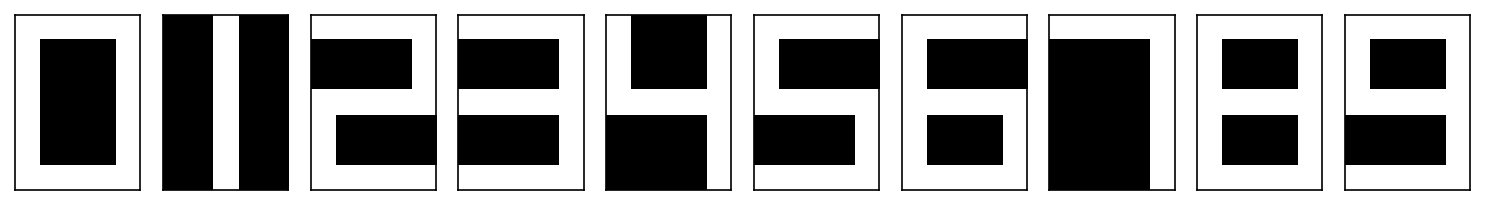

In [104]:
img_shape = (7, 5)
img_size = 35

data_path = Path(r'D:/Development/Data/datasets/txt/numbers_7x5.txt')
data_mtrx = np.loadtxt(data_path)

fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(150)
fig.set_figwidth(10)
fig.set_figheight(5)

for n, ax in zip(data_mtrx, axes.ravel()):
    ax.imshow(n.reshape(img_shape), cmap='binary_r')
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()

In [105]:
def one_hot_encoding(n: int, idx: int) -> np.ndarray:
    q = np.zeros(n)
    q[idx] = 1.0
    return q

In [106]:
features = []
labels = []

for i, reference_sample in enumerate(data_mtrx):
    features.append(reference_sample)
    labels.append(one_hot_encoding(10, i))

    for j in range(9):
        noised_sample = reference_sample + np.random.uniform(0.0, 0.25, img_size)
        
        features.append(noised_sample)
        labels.append(one_hot_encoding(10, i))

features = np.array(features)
labels = np.array(labels)

In [107]:
test_frac = 0.2

p = np.arange(10)

test_size = int(p.size * test_frac)
train_size = int(p.size * (1 - test_frac))

idx_test = np.ravel([(p[0:test_size] + i * 10) for i in range(10)])
idx_train = np.ravel([(p[test_size:p.size] + i * 10) for i in range(10)])

x_test = np.array(features[idx_test])
y_test = np.array(labels[idx_test])

x_train = np.array(features[idx_train])
y_train = np.array(labels[idx_train])

In [108]:
@njit(fastmath=True)
def ident(x: np.ndarray) -> np.ndarray:
    return x


@njit(fastmath=True)
def dIdent(x: np.ndarray) -> np.ndarray:
    return np.ones(x.shape)


@njit(fastmath=True)
def relu(x: np.ndarray) -> np.ndarray:
    return np.maximum(np.zeros(x.shape), x)


@njit(fastmath=True)
def dRelu(x: np.ndarray) -> np.ndarray:
    return 1 * (x > 0)


@njit(fastmath=True)
def tanh(x: np.ndarray) -> np.ndarray:
    return np.tanh(x)


@njit(fastmath=True)
def dTanh(x: np.ndarray) -> np.ndarray:
    return 1-np.square(np.tanh(x))


@njit(fastmath=True)
def sigmoid(x: np.ndarray) -> np.ndarray:
    return 1/(1+np.exp(-x))


@njit(fastmath=True)
def dSigmoid(x: np.ndarray) -> np.ndarray:
    y = 1/(1+np.exp(-x))
    return y*(1-y)


@njit(fastmath=True)
def softmax(x: np.ndarray) -> np.ndarray:
    y = np.exp(x)
    return y/np.sum(y)

In [133]:
@njit(fastmath=True)
def grads(xBatch: np.ndarray, yBatch: np.ndarray, w: np.ndarray, Wh: np.ndarray, Bh:np.ndarray, Bz:np.ndarray, b:np.ndarray) -> tuple[np.ndarray]:
    dWh = np.zeros(Wh.shape)
    dw = np.zeros(w.shape)
    
    dBh = np.zeros(Bh.shape)
    dBz = np.zeros(Bz.shape)
    db = np.zeros(b.shape)

    h = np.zeros((Wh.shape[0], Wh.shape[1]))
    z = np.zeros(Wh.shape[2])
    
    for i in prange(xBatch.shape[0]):
        h *= 0
        z *= 0

        for j in prange(Wh.shape[0]):
            h[j] = Wh[j] @ xBatch[i] + Bh[j]
            z += Wh[j].T @ sigmoid(h[j]) + Bz[j]

        y = softmax(w @ z + b)

        dLdz = w.T @ (y-yBatch[i])
                
        for j in prange(Wh.shape[0]):
            dLdh = Wh[j] @ dLdz * dSigmoid(h[j])

            dWh[j] += np.outer(dLdh, xBatch[i])
            dBh[j] += dLdh
            dBz[j] += dLdz
        
        dw += np.outer(y-yBatch[i], z)
        db += y-yBatch[i]
    
    return (dWh, dw, dBh, dBz, db)

class RBMPerceptron:
    def __init__(self, nL:int, nH:int, nIn:int, nOut:int) -> None:
        self.nL = nL
        self.nH = nH
        self.nIn = nIn
        self.nOut = nOut
                
        self.Wh: np.ndarray = np.random.uniform(-1, 1, (nL, nH, nIn))
        self.w: np.ndarray = np.random.uniform(-1, 1, (nOut, nIn))
        
        self.Bh: np.ndarray = np.zeros((nL, nH))
        self.Bz: np.ndarray = np.zeros((nL, nIn))
        self.b: np.ndarray = np.zeros(nOut)

    def predict(self, x:np.ndarray) -> np.ndarray:
        z = np.zeros(self.nIn)
        
        for i in range(self.Wh.shape[0]):
            h = sigmoid(self.Wh[i] @ x + self.Bh[i])
            z += self.Wh[i].T @ h + self.Bz[i]
            
        return softmax(self.w @ z + self.b)

    def train(self, x_train: np.ndarray, y_train: np.ndarray, lr, batch_size, max_epoch) -> None:
        n = x_train.shape[0]

        for epoch in range(max_epoch):
            idxs = np.random.permutation(n)

            for batch_idx in range(n//batch_size):
                ibegin, iend = batch_idx*batch_size, min((batch_idx+1)*batch_size, n-1)
                batch_idxs = idxs[ibegin:iend]
            
                dWh, dw, dBh, dBz, db = grads(x_train[batch_idxs], y_train[batch_idxs], self.w, self.Wh, self.Bh, self.Bz, self.b)
                
                self.Wh -= lr*dWh
                self.Bh -= lr*dBh
                self.Bz -= lr*dBz
                
                self.w -= lr*dw
                self.b -= lr*db
        
    def loss(self, x: np.ndarray, y: np.ndarray) -> float:
        Ypred = np.array([self.predict(xi) for xi in x])
        h = -np.mean(y*np.log(Ypred), axis=1)
        return np.mean(h)

In [140]:
nL = 5
nH = 5
nIn = 35
nOut = 10

lr = 1e-2
batch_size = 8
max_epoch = 256

model = RBMPerceptron(nL, nH, nIn, nOut)

print('untrained loss: ', model.loss(x_test, y_test).round(6))

model.train(
    x_train,
    y_train,
    lr,
    batch_size,
    max_epoch
)

print('trained loss: ', model.loss(x_test, y_test).round(6))

n_true_pos = 0

for x, y in zip(x_test, y_test):
    ypred = model.predict(x)
    n_true_pos += 1 if np.argmax(ypred) == np.argmax(y) else 0

accuracy = n_true_pos / x_test.shape[0]
print(f"test set accuracy: {round(accuracy * 100, 2)}%")

untrained loss:  0.950032
trained loss:  0.000448
test set accuracy: 100.0%


In [141]:
n_samples = 10000
noise_size = 1.0

n_true_pos = 0

for i in range(n_samples):
    j = i % 10
    x = data_mtrx[j] + np.random.uniform(0, noise_size, img_size)
    y = model.predict(x)
    n_true_pos += 1 if j == np.argmax(y) else 0

print(f"accuracy: {round(n_true_pos / n_samples * 100, 2)}%")

accuracy: 78.23%


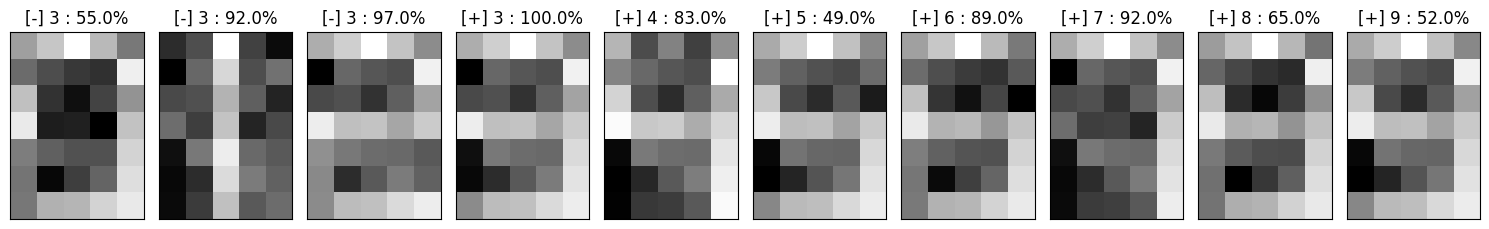

In [126]:
noise_size = 1.0

x_noised = data_mtrx + np.random.uniform(0.0, noise_size, img_size)
y = list([model.predict(xi) for xi in x_noised])

fig, axes = plt.subplots(nrows=1, ncols=10)

fig.set_dpi(100)
fig.set_figwidth(15)
fig.set_figheight(5)

for i, ax in enumerate(axes.ravel()):
    ax.imshow(x_noised[i].reshape(img_shape),  cmap='binary_r')
    j = np.argmax(y[i])

    ax.set_title(f"[{'+' if j == i else '-'}] {j} : {(y[i][j] * 100).round()}%")
    ax.set_xticks([])
    ax.set_yticks([])

plt.tight_layout()
plt.show()